<a href="https://colab.research.google.com/github/eviatarbach/variational_filtering/blob/main/Kuramoto_Sivashinsky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle
from jax import random
from jax import jit
from jax.scipy.linalg import svd
from jax.numpy.fft import fft, ifft
import jax

In [2]:
import pickle
import matplotlib.pyplot as plt
import os
import glob

directory = '/central/home/eluk/variational_filtering/experiment_data/'

# List all files in the directory 
files = glob.glob(os.path.join(directory, '*.pkl'))

if files:
    most_recent_file = max(files, key=os.path.getmtime)
    print(f"Most recent file: {most_recent_file}")

    #most_recent_file = '/central/home/eluk/variational_filtering/experiment_data/ks_experiment_2024-02-18_02-54-56.pkl'


    with open(most_recent_file, 'rb') as f:
        loaded_data = pickle.load(f)
else:
    print("No files found in the specified directory.")

Most recent file: /central/home/eluk/variational_filtering/experiment_data/ks_experiment_2024-02-29_00-08-43.pkl


/tmp/ipykernel_82068/556173375.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(base_colors[radius_index])


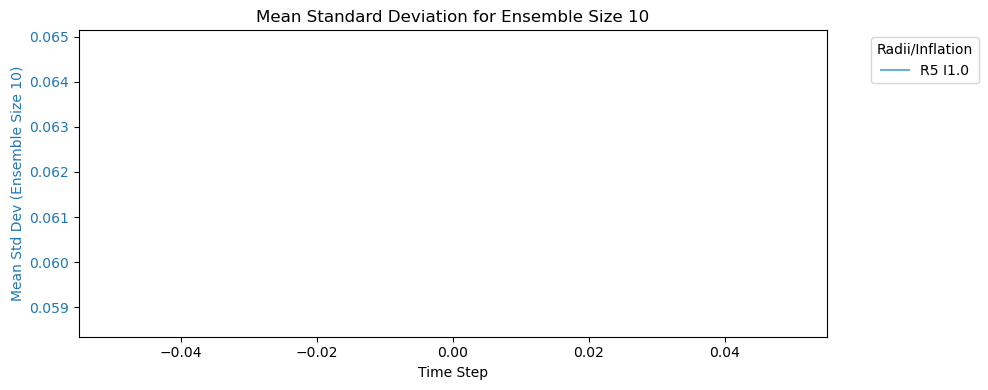

In [3]:
std_errors = loaded_data['std_errors']
errors = loaded_data['errors']
parameters = loaded_data['parameters']


radii = parameters['radii']
inflations = parameters['inflations']
ensemble_sizes = parameters['ensemble_sizes']
num_trials = parameters['num_trials']


mean_std_errors = {(radius, inflation, n_ensemble): np.mean(np.vstack(std_errors[(radius, inflation, n_ensemble)]), axis=0)
                   for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
mean_errors = {(radius, inflation, n_ensemble): np.mean(np.vstack(errors[(radius, inflation, n_ensemble)]), axis=0)
               for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}


num_ensemble_sizes = len(ensemble_sizes)
fig, axs = plt.subplots(num_ensemble_sizes, 1, figsize=(10, num_ensemble_sizes * 4))  # Adjust figsize as needed

base_colors = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges']

# Check if we have more than one subplot to iterate correctly
if num_ensemble_sizes > 1:
    ax_iter = axs.flat
else:
    ax_iter = [axs]

for ax, n_ensemble in zip(ax_iter, ensemble_sizes):
    for radius_index, radius in enumerate(radii[1:]):
        cmap = plt.cm.get_cmap(base_colors[radius_index])
        num_inflations = len(inflations)
        colors = [cmap(0.5 + i / (2 * num_inflations)) for i in range(num_inflations)]

        for inflation_index, inflation in enumerate(inflations):
            color = colors[inflation_index]
            label = f"R{radius} I{inflation}"
            mean_std = mean_std_errors[(radius, inflation, n_ensemble)]
            ax.plot(mean_std, label=label, color=color)

    ax.set_xlabel('Time Step')
    ax.set_ylabel(f'Mean Std Dev (Ensemble Size {n_ensemble})', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.legend(title='Radii/Inflation', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f"Mean Standard Deviation for Ensemble Size {n_ensemble}")

plt.tight_layout()
plt.show()


/tmp/ipykernel_82068/92186246.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(base_colors[radius_index])


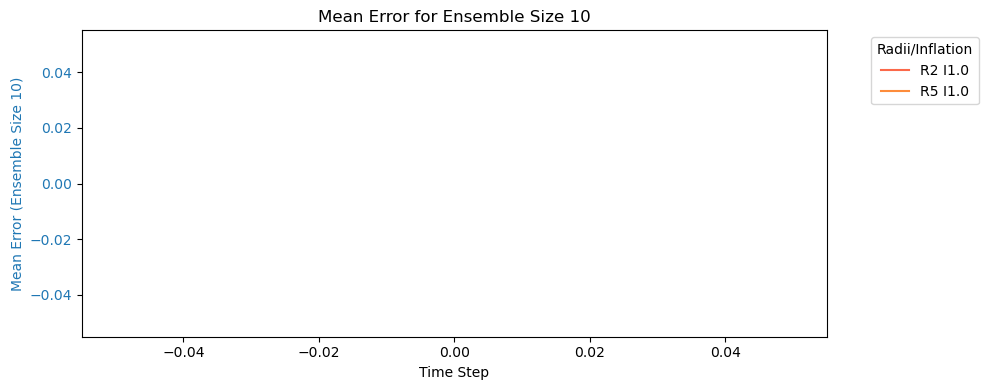

In [4]:
num_ensemble_sizes = len(ensemble_sizes)
fig, axs = plt.subplots(num_ensemble_sizes, 1, figsize=(10, num_ensemble_sizes * 4))  # Adjust figsize as needed

base_colors = ['Reds', 'Oranges', 'Greens', 'Blues', "Purples"]
# Check if we have more than one subplot to iterate correctly
if num_ensemble_sizes > 1:
    ax_iter = axs.flat
else:
    ax_iter = [axs]

for ax, n_ensemble in zip(ax_iter, ensemble_sizes):
    for radius_index, radius in enumerate(radii):
        cmap = plt.cm.get_cmap(base_colors[radius_index])
        num_inflations = len(inflations)
        colors = [cmap(0.5 + i / (2 * num_inflations)) for i in range(num_inflations)]
        for inflation_index, inflation in enumerate(inflations):
            color = colors[inflation_index]
            label = f"R{radius} I{inflation}"
            mean_error = mean_errors[(radius, inflation, n_ensemble)][1:]
            ax.plot(mean_error, label=label, color=color)

    ax.set_xlabel('Time Step')
    ax.set_ylabel(f'Mean Error (Ensemble Size {n_ensemble})', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.legend(title='Radii/Inflation', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f"Mean Error for Ensemble Size {n_ensemble}")

plt.tight_layout()
#plt.show()


In [8]:
mean_errors

{(2,
  1.0,
  10): Array([0.80301607,        nan,        nan,        nan], dtype=float32),
 (5,
  1.0,
  10): Array([0.8044014,       nan,       nan,       nan], dtype=float32)}

In [60]:
observation_times = np.arange(5, num_steps, observation_interval)

np.mean(mean_std_errors[(2,1,30)][observation_times])

KeyError: (2, 1, 30)

In [6]:
mean_std_errors[(2,1,30)]


KeyError: (2, 1, 30)

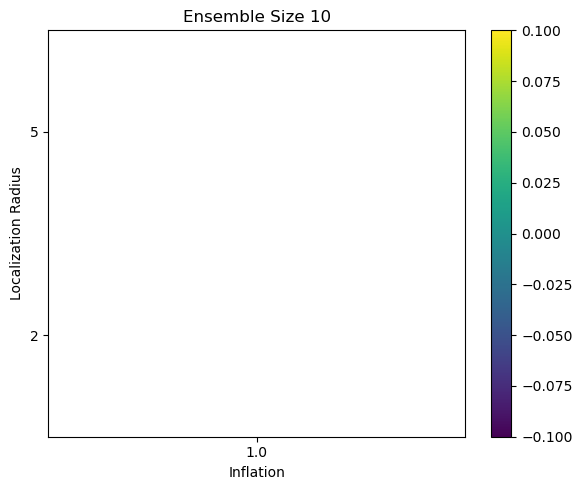

In [7]:

total_errors = {(radius, inflation, n_ensemble): np.mean(mean_errors[(radius, inflation, n_ensemble)][observation_times]) for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}

num_ensemble_sizes = len(ensemble_sizes)
fig, axs = plt.subplots(1, num_ensemble_sizes, figsize=(num_ensemble_sizes * 6, 5))

if num_ensemble_sizes == 1:
    axs = [axs]

for idx, n_ensemble in enumerate(ensemble_sizes):
    # Create a matrix to store total errors for heatmap plotting
    error_matrix = np.zeros((len(radii), len(inflations)))

    for i, radius in enumerate(radii):
        for j, inflation in enumerate(inflations):
            error_matrix = error_matrix.at[i, j].set(total_errors[(radius, inflation, n_ensemble)])

    # Plotting
    cax = axs[idx].imshow(error_matrix, cmap='viridis', origin='lower', aspect='auto')
    axs[idx].set_title(f'Ensemble Size {n_ensemble}')
    axs[idx].set_xticks(np.arange(len(inflations)))
    axs[idx].set_yticks(np.arange(len(radii)))
    axs[idx].set_xticklabels(inflations)
    axs[idx].set_yticklabels(radii)
    axs[idx].set_xlabel('Inflation')
    axs[idx].set_ylabel('Localization Radius')

    # Adding colorbar to each subplot
    fig.colorbar(cax, ax=axs[idx], orientation='vertical')

plt.tight_layout()
plt.show()


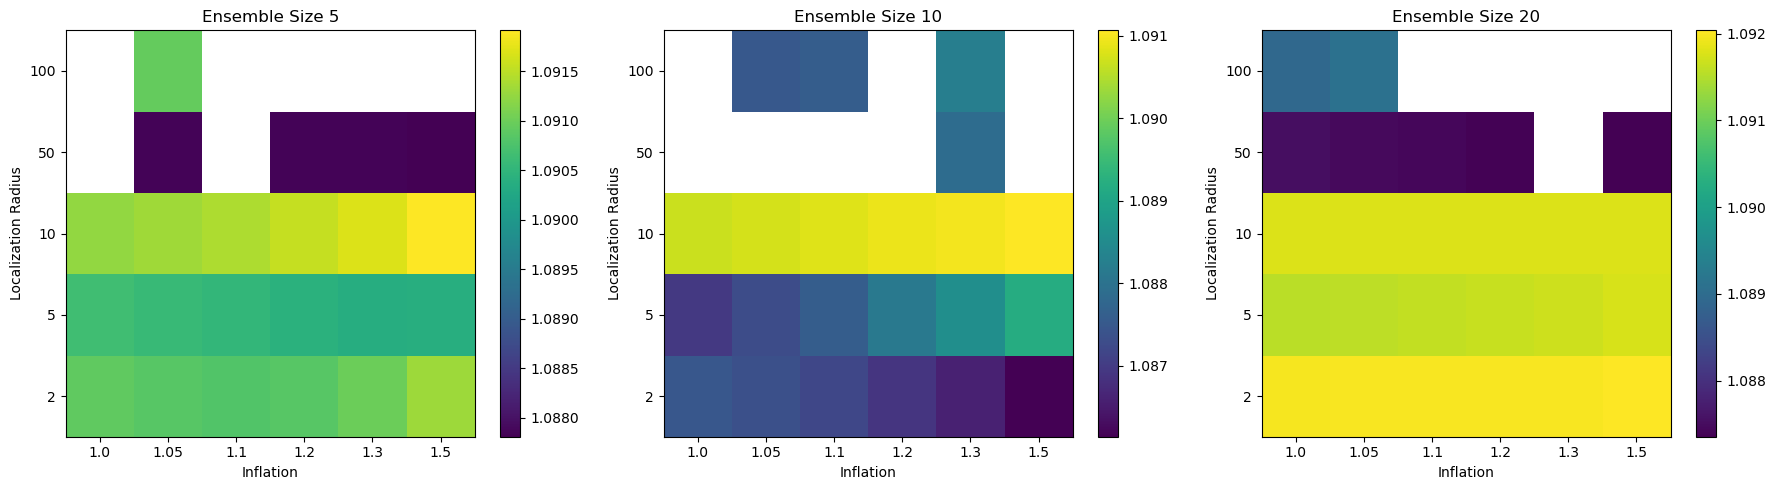

In [65]:

total_std = {(radius, inflation, n_ensemble): np.mean(mean_std_errors[(radius, inflation, n_ensemble)][observation_times]) for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}

num_ensemble_sizes = len(ensemble_sizes)
fig, axs = plt.subplots(1, num_ensemble_sizes, figsize=(num_ensemble_sizes * 6, 5))

if num_ensemble_sizes == 1:
    axs = [axs]

for idx, n_ensemble in enumerate(ensemble_sizes):
    # Create a matrix to store total errors for heatmap plotting
    error_matrix = np.zeros((len(radii), len(inflations)))

    for i, radius in enumerate(radii):
        for j, inflation in enumerate(inflations):
            error_matrix = error_matrix.at[i, j].set(total_std[(radius, inflation, n_ensemble)])

    # Plotting
    cax = axs[idx].imshow(error_matrix, cmap='viridis', origin='lower', aspect='auto')
    axs[idx].set_title(f'Ensemble Size {n_ensemble}')
    axs[idx].set_xticks(np.arange(len(inflations)))
    axs[idx].set_yticks(np.arange(len(radii)))
    axs[idx].set_xticklabels(inflations)
    axs[idx].set_yticklabels(radii)
    axs[idx].set_xlabel('Inflation')
    axs[idx].set_ylabel('Localization Radius')

    # Adding colorbar to each subplot
    fig.colorbar(cax, ax=axs[idx], orientation='vertical')

plt.tight_layout()
plt.show()


In [56]:
import numpy as np

# Assuming mean_errors is defined somewhere above
# And radii, inflations, ensemble_sizes are also defined

for radius in radii:
    for inflation in inflations:
        for n_ensemble in ensemble_sizes:
            key = (radius, inflation, n_ensemble)
            data = mean_errors[key]
            num_values = len(data)  # Total number of values
            num_nans = np.sum(np.isnan(data))  # Count of NaN values
            percent_nans = (num_nans / num_values) * 100  # Percentage of NaN values
            
            print(f"{key}: {percent_nans:.2f}% NaNs")


(2, 1.0, 30): 0.00% NaNs
(2, 1.0, 40): 0.00% NaNs
(2, 1.05, 30): 0.00% NaNs
(2, 1.05, 40): 0.00% NaNs
(2, 1.1, 30): 0.00% NaNs
(2, 1.1, 40): 0.00% NaNs
(2, 1.2, 30): 0.00% NaNs
(2, 1.2, 40): 0.00% NaNs
(2, 1.3, 30): 0.00% NaNs
(2, 1.3, 40): 0.00% NaNs
(2, 1.5, 30): 0.00% NaNs
(2, 1.5, 40): 0.00% NaNs
(5, 1.0, 30): 0.00% NaNs
(5, 1.0, 40): 0.00% NaNs
(5, 1.05, 30): 0.00% NaNs
(5, 1.05, 40): 0.00% NaNs
(5, 1.1, 30): 0.00% NaNs
(5, 1.1, 40): 0.00% NaNs
(5, 1.2, 30): 0.00% NaNs
(5, 1.2, 40): 0.00% NaNs
(5, 1.3, 30): 0.00% NaNs
(5, 1.3, 40): 0.00% NaNs
(5, 1.5, 30): 0.00% NaNs
(5, 1.5, 40): 0.00% NaNs
(10, 1.0, 30): 0.00% NaNs
(10, 1.0, 40): 0.00% NaNs
(10, 1.05, 30): 0.00% NaNs
(10, 1.05, 40): 0.00% NaNs
(10, 1.1, 30): 0.00% NaNs
(10, 1.1, 40): 0.00% NaNs
(10, 1.2, 30): 0.00% NaNs
(10, 1.2, 40): 0.00% NaNs
(10, 1.3, 30): 0.00% NaNs
(10, 1.3, 40): 0.00% NaNs
(10, 1.5, 30): 0.00% NaNs
(10, 1.5, 40): 0.00% NaNs
(50, 1.0, 30): 37.50% NaNs
(50, 1.0, 40): 3.50% NaNs
(50, 1.05, 30): 0.00% NaNs
(5